<a href="https://colab.research.google.com/github/JosenildoVicente/Algoritmo-de-agrupamento-adaptavel-baseado-em-kNN-e-densidade/blob/main/ACND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [353]:
import pandas as pd
import numpy as np

from google.colab import files
import io
import numpy.ma as ma
from scipy.spatial import distance as dist


In [354]:
data = pd.read_csv( "https://raw.githubusercontent.com/JosenildoVicente/Algoritmo-de-agrupamento-adaptavel-baseado-em-kNN-e-densidade/main/Aggregation.csv", encoding="ISO-8859-1" )

In [355]:
data.rename(columns = {' Col_1': 'Col_1'}, inplace = True)

In [356]:
data.head()

,Col_0,Col_1
0,15.55,28.65
1,14.90,27.55
2,14.45,28.35
3,14.15,28.80
4,13.75,28.05


# Etapa 1: Read and analyze data, and determine parameters

In [357]:
N = data.shape[0]
alfa = 0.0
alpha = 0.0
beta = 0.0
gama = 0.0


In [358]:
for m in data:

  max_s = max(data[m])
  min_s = min(data[m])
  rs = max_s - min_s
  alfa += rs

alpha = N/alfa
beta = ((3.5 * alpha) + 45) / 100
gama = ( (2 * alpha) + 18)/100
k = max(10, (N * 0.01))


#Etapa 2: Construct k-D Tree: kDT

In [359]:
from sklearn.neighbors import KDTree
kdt = KDTree(data)

In [ ]:
kdt.get_arrays()

#Etapa 3: Searches kNN of sample, calculates mean of 5NN’s

In [361]:
distance = []
knn_index = []
d5nn = []

distance, knn_index = kdt.query(data,k)

for i in range(len(knn_index)):
  d5nn.append(np.mean(distance[i, 1:6]))


#Etapa 4: Calculate the global radius of SR

In [362]:
d5nn = np.sort(d5nn)

In [363]:
R = max(d5nn)
R

1.8010955367628583

#Etapa 5: Calculate sample density array(Rho)

In [364]:
def fab(i, j, a, b):
  d = dist.euclidean(i, j)
  if d >= 0 and d <= a:
    return 1
  elif d > a and d <= b:
    return ((b - d)/ (b-a))
  elif d > b:
    return 0

In [365]:
rho = []
for i in range(N):
  rho.append(0)
surrounding_region = []
for i in range(N):
  surrounding_region = distance[i,] < R
  surrounding_region = distance[i,surrounding_region]
  surrounding_region = surrounding_region[1:]

  mean_ = np.mean(surrounding_region)
  std_dev = np.std(surrounding_region)
  surrounding_region = np.sort(surrounding_region)
  d1 = surrounding_region[0]

  d2 = min(surrounding_region)
  a = (d1 + d2)/2
  exp = (a + 2*std_dev)
  b = min( exp, R)

  for j in surrounding_region:#range(len(surrounding_region)):
    f = fab(np.mean(distance[i]),j,a,b)
    rho[i] += f


#Etapa 6: Calculate the global density threshold(T)

In [366]:

arr = []
for i in range(N):
  arr.append((rho[i], i))

arr = np.sort(arr,0)
arr = arr[::-1]

t = np.percentile(arr, 25) 
t = t/2
print(t)

4.5


#Etapa 7: Clustering

In [367]:
def existe(arr, valor):
  for i in arr:
    if i == valor:
      return True
  return False

In [368]:
order_of_cluster = 0
tag = []
for i in range(N):
  tag.append(False)
queue = []
queue_2 = []

result = []
for y in range(N):
  result.append(0)

for ind in range(N):
  # 1 representa indice e 0 valor de arr
  if ( tag[np.int(arr[ind][1])]):
    continue
  if (arr[ind][0] == 0):
    tag[np.int(arr[ind][1])] = True
    continue
  if ( arr[ind][0] < t ):
    continue

  order_of_cluster += 1
  tag[ np.int(arr[ind][1]) ] = True
  queue.clear()
  queue.append(arr[ind][1])
  queue_2.append(arr[ind][1])
  print(queue)
  while (len(queue) > 0):
    i = queue.pop(0)

    aver = (t + rho[np.int(i)]) / 2
    local_t = aver * beta

    for e in range(k):
      j = knn_index[np.int(i)][e]

      if (distance[np.int(i)][e] > R):
        continue
      
      co_nn = 0
      for a in range(1,10):
        for b in range(1,10):
          if (knn_index[np.int(i)][a] == knn_index[j][b]):
            co_nn += 1

      tag[j] = True

      if (rho[j]):
        result[j] = order_of_cluster 
        if (rho[j] >= local_t and co_nn > (k * gama)):   #(Rho[j] > = localT && co_NN > k ∗γ )
          if (not existe(queue_2,j)):
            queue.append(j)
            queue_2.append(j)


[787.0]
[753.0]
[730.0]
[708.0]
[613.0]
[577.0]
[476.0]
[394.0]
[317.0]
[169.0]
[126.0]


#Etapa 8: Post–Process clustering and save the results

In [369]:
cluster = 1
for cluster in range(order_of_cluster):
  cont = 0
  for i in result:
    if (i == cluster):
      cont += 1

  if ( cont <= 5 ):
    for j in range(N):
      if (result[j] == cluster ):
        result[j] = 0

for i in range(79):
  print(i*10,end=" ")
  if i == 78:
    for j in range(8):
      print(result[( (i*10) + j )],end=" ")
  else:
    for j in range(10):
      print(result[( (i*10) + j )],end=" ")
  print(" ")

0 10 10 10 10 10 10 10 10 10 10  
10 10 10 10 10 10 10 10 10 10 10  
20 10 10 10 10 10 10 10 10 10 10  
30 10 10 10 10 10 10 10 10 10 10  
40 10 10 10 10 10 10 10 10 10 11  
50 11 11 11 10 11 11 11 11 10 10  
60 10 10 10 10 10 10 10 10 10 10  
70 10 10 10 10 10 10 10 10 10 10  
80 10 10 10 11 10 10 10 10 10 10  
90 10 10 10 10 10 10 11 10 11 11  
100 10 10 10 10 10 10 10 10 10 10  
110 11 10 10 10 10 10 10 10 10 10  
120 11 11 11 11 11 11 11 11 11 10  
130 10 10 10 10 10 11 11 11 11 11  
140 11 11 11 10 10 10 10 10 11 11  
150 11 10 10 10 10 10 10 10 10 10  
160 10 10 10 10 10 10 10 10 10 10  
170 7 7 7 7 7 7 7 7 7 7  
180 7 7 7 7 7 7 7 7 7 7  
190 7 7 7 7 7 7 7 7 7 7  
200 7 7 7 7 7 7 7 7 7 7  
210 7 7 7 7 7 7 7 7 7 7  
220 7 7 7 7 7 7 7 7 7 7  
230 7 7 7 7 7 7 7 7 7 7  
240 7 7 7 7 7 7 7 7 7 7  
250 7 7 7 7 7 7 7 7 7 7  
260 7 7 7 7 7 7 7 7 7 7  
270 7 7 7 7 7 7 7 7 7 7  
280 7 7 7 7 7 7 7 7 7 7  
290 7 7 7 7 7 7 7 7 7 7  
300 7 7 7 7 7 9 9 9 9 9  
310 7 7 7 9 9 9 9 9 9 9  
320 9 9 9

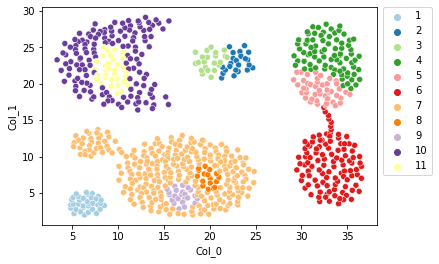

In [370]:
from matplotlib import pyplot as plt
import seaborn as sns

tag = result
g =sns.scatterplot(x="Col_0", y="Col_1",
              hue=tag,palette ="Paired",
              data=data)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
